# New Target
This notebook is a revised analysis for the project. We are revising our analysis as we have to change our target variable. This is because the difficulty in distinguishing whether a search was conducted or not. Because of this, we're changing our target variable to the **result of stop**. See the first notebook for more explanation. 
## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size':13})
import seaborn as sns

## Data Prep
In this section we'll prep our data for visualizations. We'll be using the methodology and data cleaning as we did from the first notebook. 

In [2]:
df = pd.read_csv("Officer_Traffic_Stops.csv")

We'll drop the object id column and the global id column because they don't provide enough information.

In [3]:
df = df.drop(columns=['OBJECTID','GlobalID'])

We'll also handle the nulls the same way.

In [4]:
df.loc[df['CMPD_Division'].isna(),'CMPD_Division'] = 'No Division'

The last thing we need to do is convert our month of stop to datetime format.

In [5]:
df['Month_of_Stop'] = pd.to_datetime(df['Month_of_Stop'])

## Feature Visualizations
We'll skip past the feature visualizations without hue as that already exists in the previous notebook. We'll instead skip towards our countplot with the hue of our new target variable.

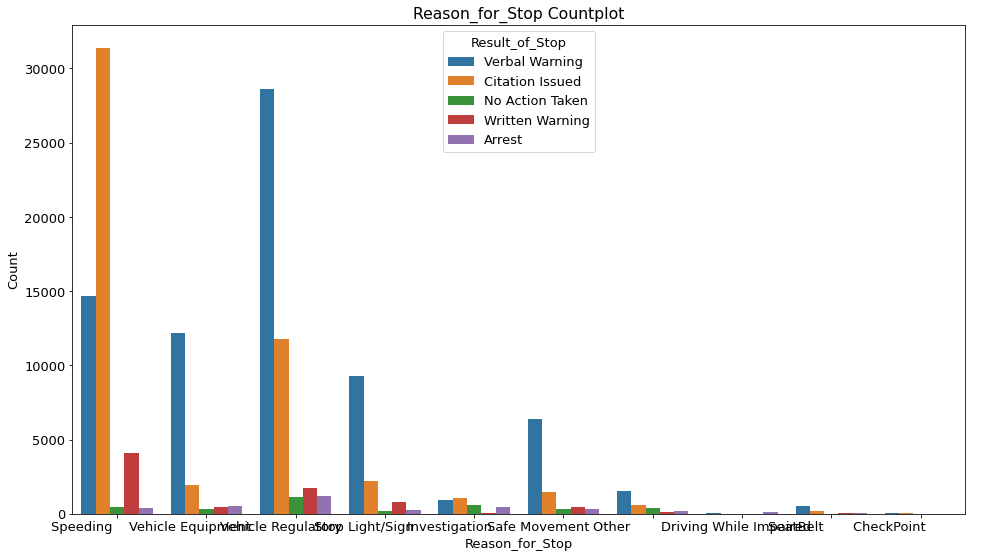

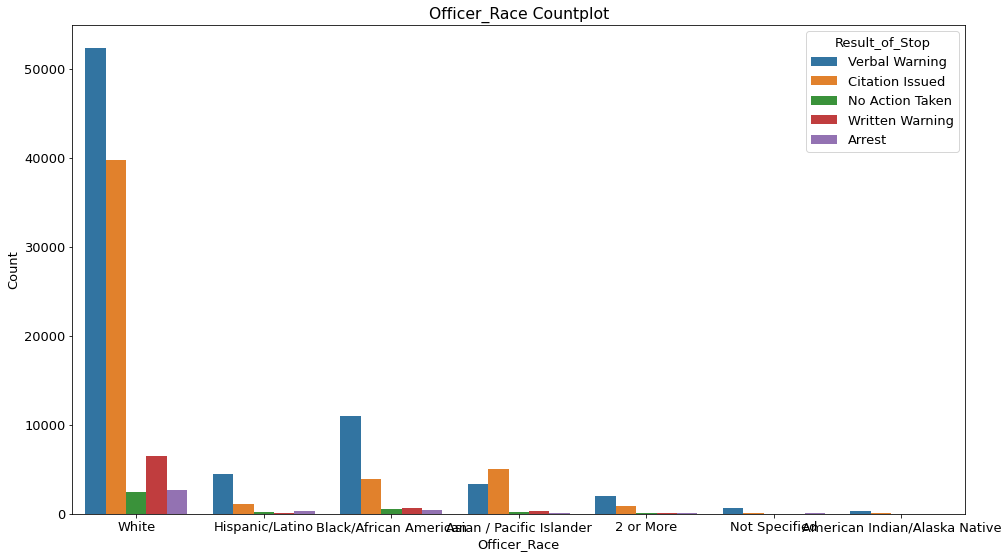

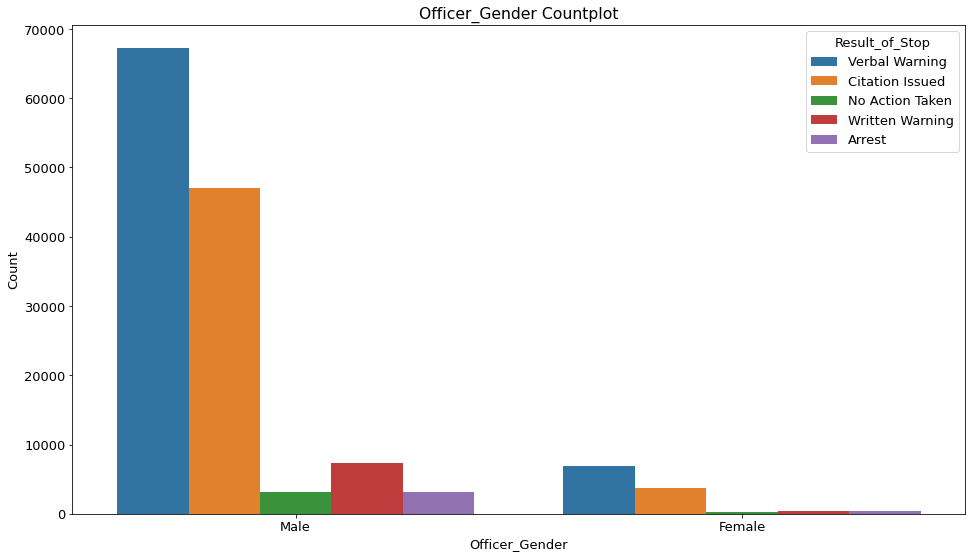

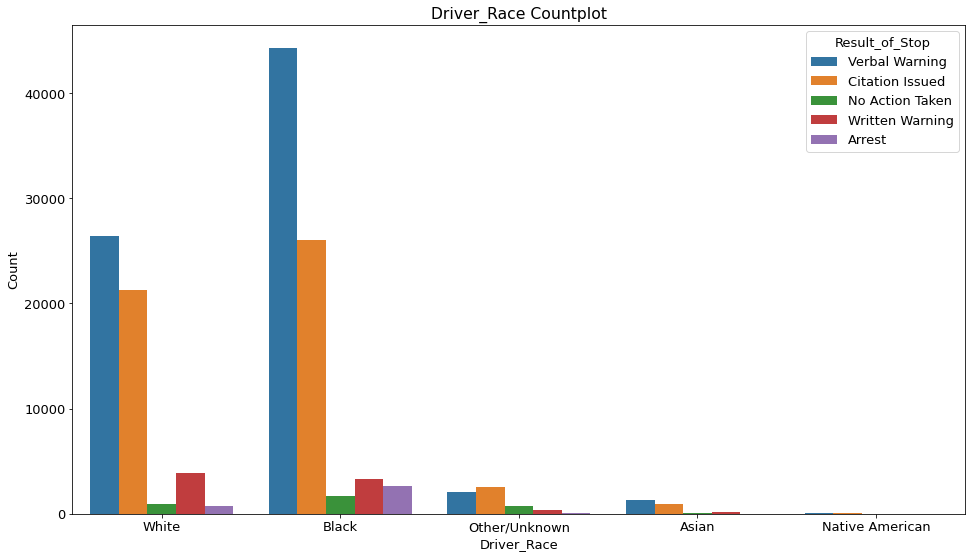

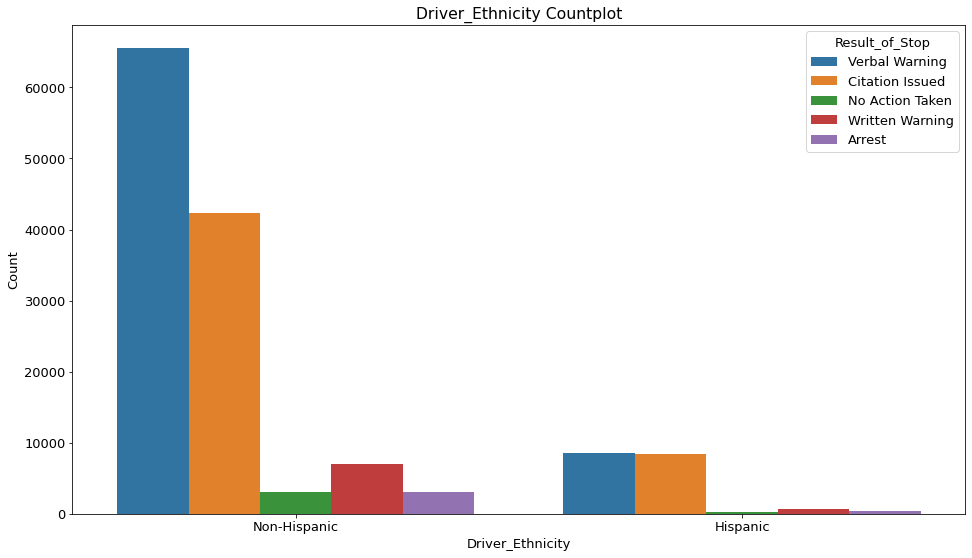

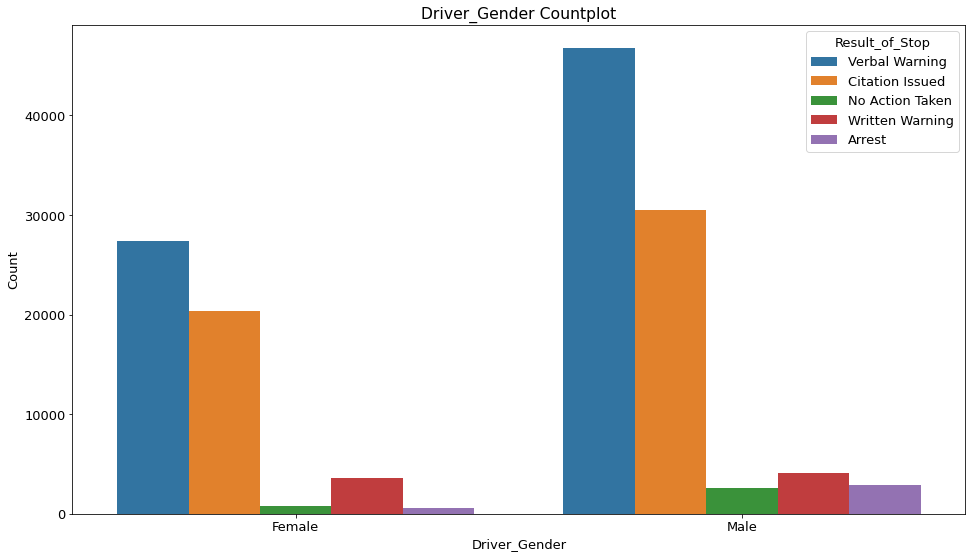

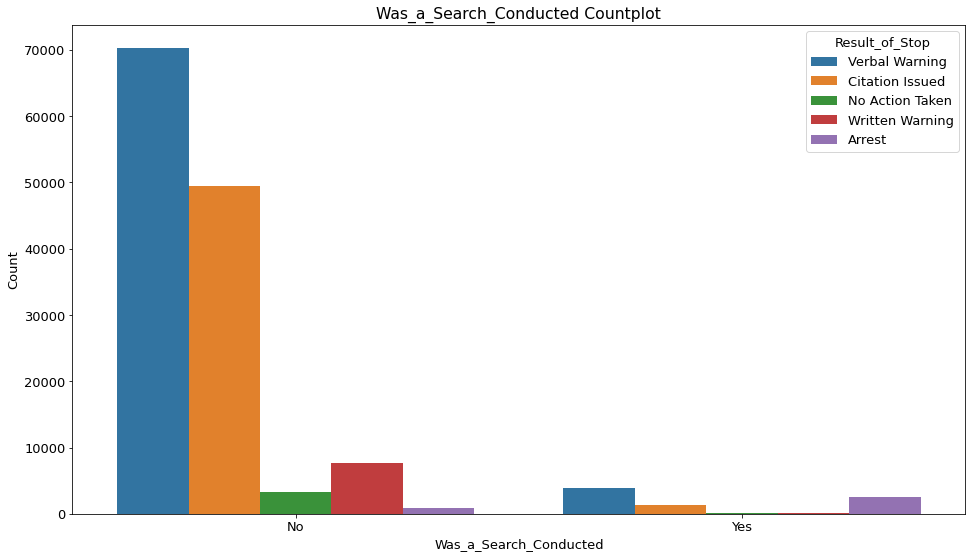

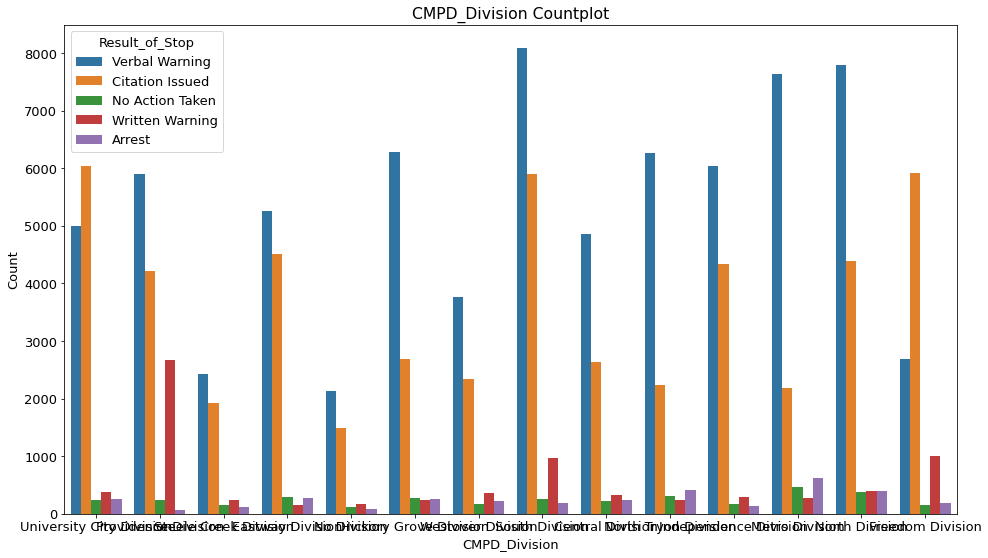

In [6]:
categoricals = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(exclude=['object']).columns
for column in categoricals.drop(labels=['Result_of_Stop']):
    plt.figure(figsize=(16,9))
    sns.countplot(x=df[column],hue=df['Result_of_Stop'])
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'{column} Countplot')
    plt.savefig(f'Graphs/{column}_New_hue_countplot.png')
    plt.show()

We can see some clear imbalance in a lot of these categories. To get a better understanding, let's standardize these to percentatges.

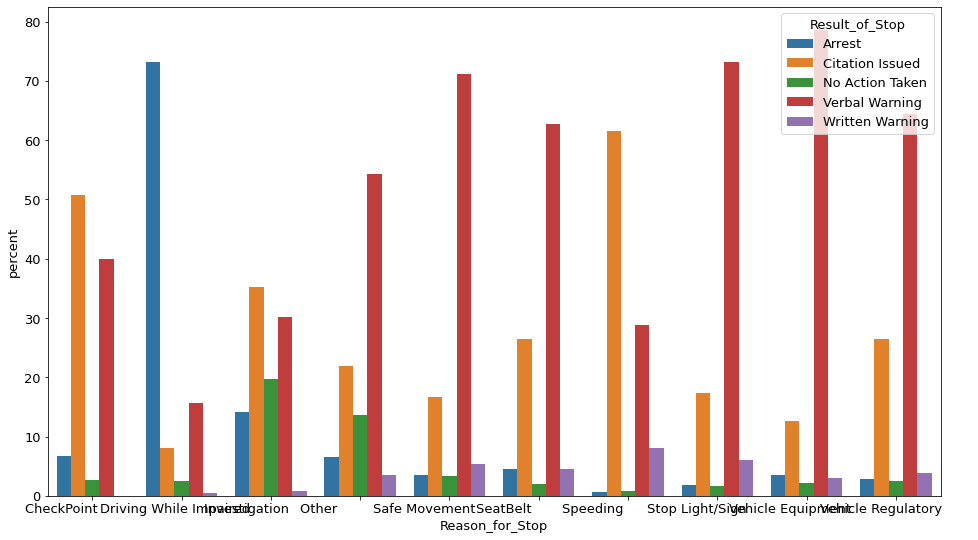

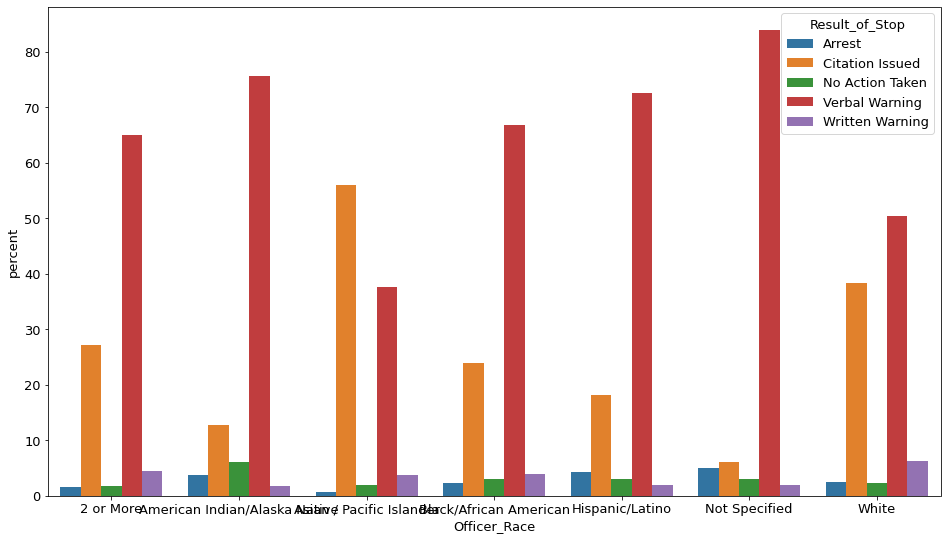

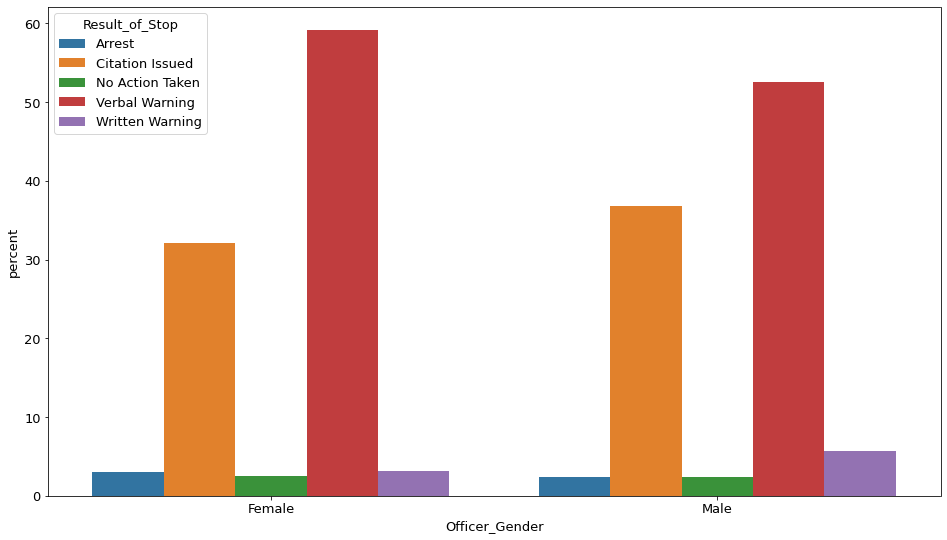

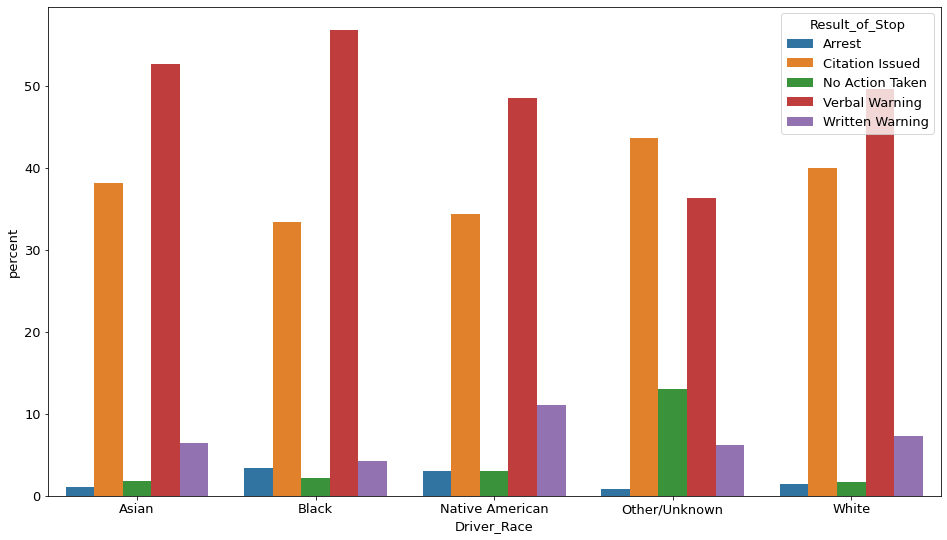

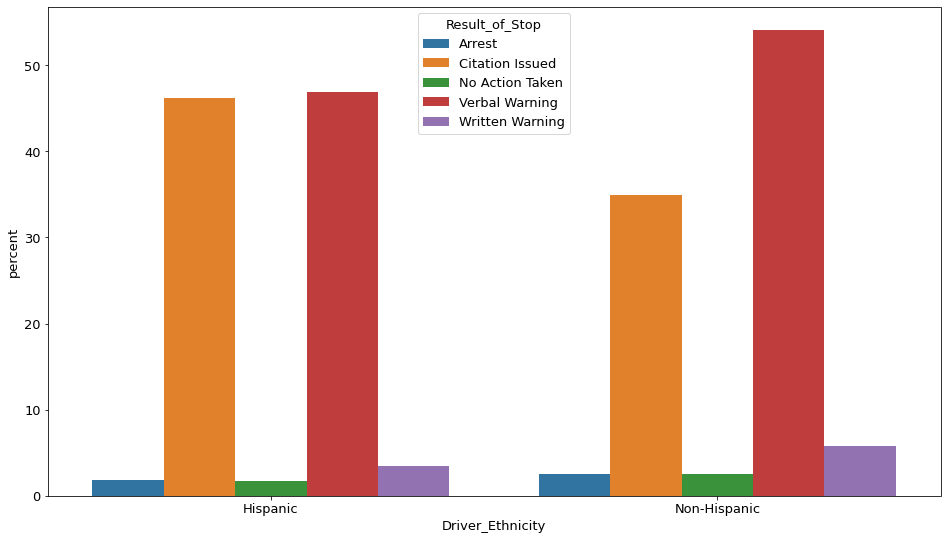

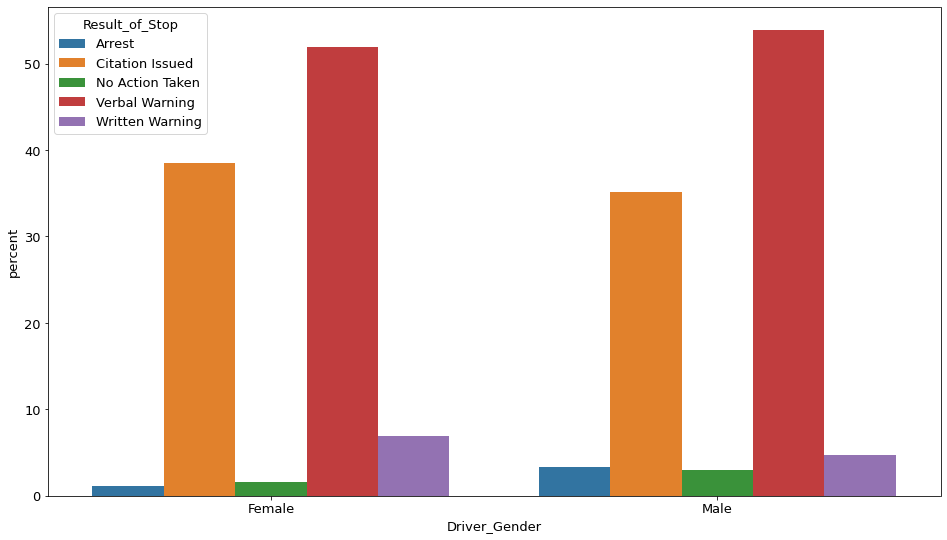

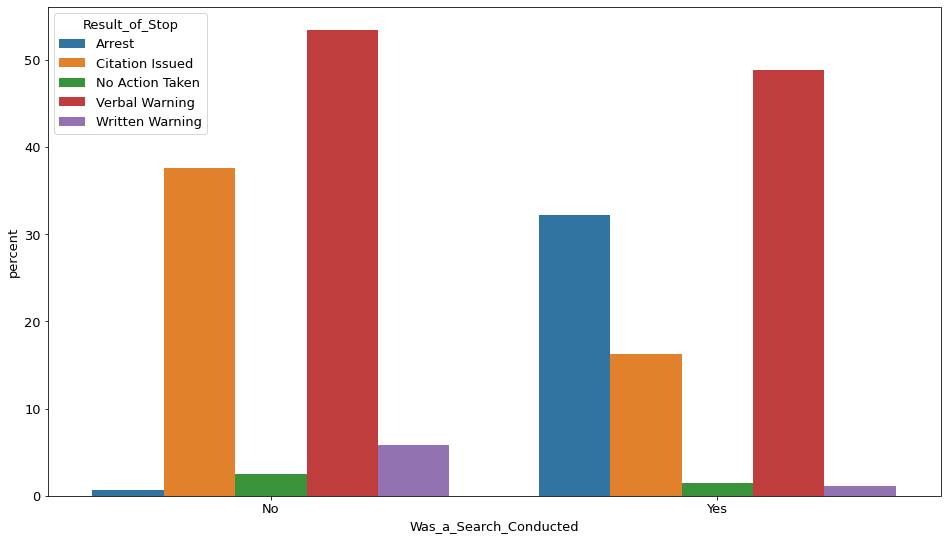

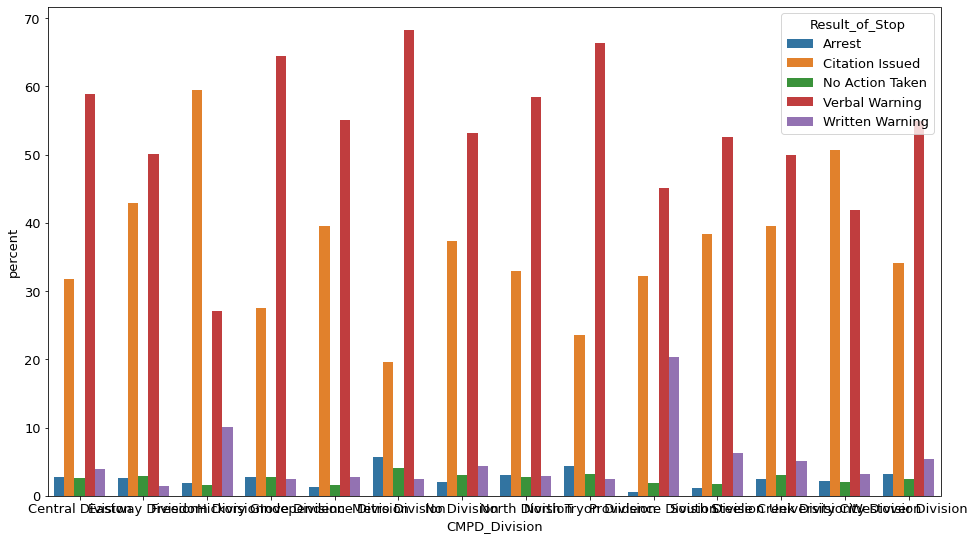

In [7]:
for column in categoricals.drop(labels=['Result_of_Stop']):
    x,y = column, 'Result_of_Stop'

    temp=(df
    .groupby(x)[y]
    .value_counts(normalize=True,sort=False)
    .mul(100)
    .rename('percent')
    .reset_index())
    plt.figure(figsize=(16,9))
    sns.barplot(x=column,y="percent",hue=y,data=temp)
    plt.savefig(f'Graphs/normalized_{column}_hue_countplot.png')
    plt.show()

## Prepping data for later use
While utilizing feature visualizations is beneficial for understand how the features interact with our target, they aren't good enough to justify dropping features. Because of this, we'll run a chi-square test of independence. We'll be utilizing the **researchpy** package for this test as it gives the chi-square test statistic, the associated p-value, and **Cramer's V**. Cramer's V measures the strength of association between different categorical features. Cramer's V is similar to Pearson's correlation coefficient as it is rated on a scale of 0 to 1. More information about Cramer's V and chiq-square tests of independence can be found in this article: https://www.pythonfordatascience.org/chi-square-test-of-independence-python/. Let's now import researchpy.

In [8]:
import researchpy as rp

Before we run the chi-square test, let's establish what Cramer's V values we would won't to have to justify using the feature in our model. The interpretation for Cramer's V values is shown below:
- Cramer's V $\ge$.25: Very Strong Association
- Cramer's V $\ge$.15: Strong Association
- Cramer's V $\ge$.10: Moderate Association
- Cramer's V $\ge$.05: Weak Association
- Cramer's V $\ge$0: No or Very Weak Association

We will be dropping features that have weak association, very weak association, or no association. 

In [9]:
cramers_V = []

for column in categoricals.drop(labels=['Result_of_Stop']):
    crosstab,test_results,expected = rp.crosstab(df['Result_of_Stop'],
                                                df[column],test='chi-square',
                                                expected_freqs=True,
                                                prop='cell')
    p_value = test_results['results'][1]
    strength = test_results['results'][2]
    cramers_V.append(strength)
    print(f'{column} likelihood of not having association with target {p_value}')
    print(f'Strength of relationship {strength}\n')


Reason_for_Stop likelihood of not having association with target 0.0
Strength of relationship 0.2644

Officer_Race likelihood of not having association with target 0.0
Strength of relationship 0.0964

Officer_Gender likelihood of not having association with target 0.0
Strength of relationship 0.0462

Driver_Race likelihood of not having association with target 0.0
Strength of relationship 0.0949

Driver_Ethnicity likelihood of not having association with target 0.0
Strength of relationship 0.0826

Driver_Gender likelihood of not having association with target 0.0
Strength of relationship 0.0953

Was_a_Search_Conducted likelihood of not having association with target 0.0
Strength of relationship 0.4716

CMPD_Division likelihood of not having association with target 0.0
Strength of relationship 0.1649



In [10]:
from matplotlib.offsetbox import AnchoredText

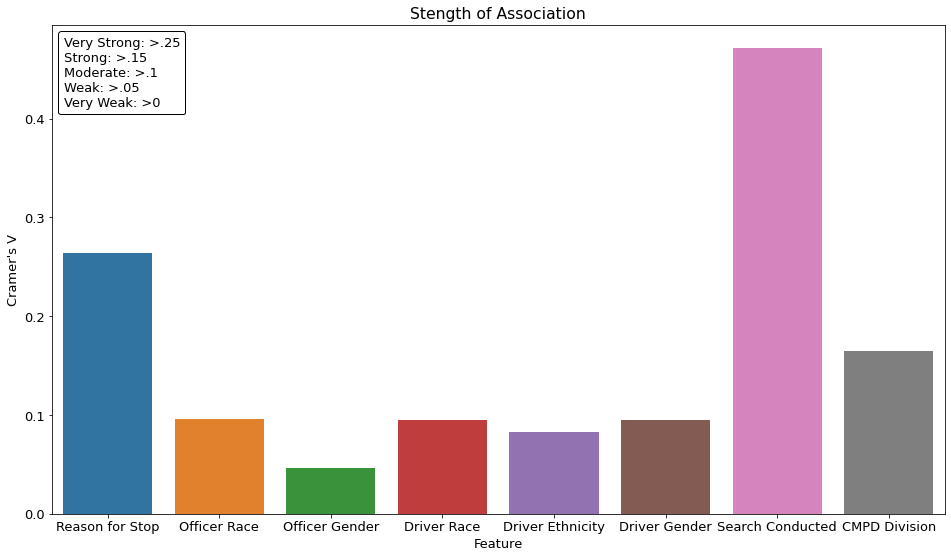

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(x = ['Reason for Stop','Officer Race','Officer Gender',
                 'Driver Race','Driver Ethnicity','Driver Gender',
                 'Search Conducted','CMPD Division'],y=cramers_V)
plt.title("Stength of Association")
plt.xlabel("Feature")
plt.ylabel("Cramer's V")
text = AnchoredText('Very Strong: >.25\nStrong: >.15\nModerate: >.1\nWeak: >.05\nVery Weak: >0',loc='upper left')
text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(text)
plt.savefig("AssociationBarplot.png")
plt.show()

Looking at these, we can choose to drop officer gender because of there not being enough of an association for us to want to use. We also choose to drop "Was a Search Conducted" as we think there is too much co-linearity with a super high Cramer's V of .4716. We'll also drop the month of stop as we still don't think it's neccessary. 

In [12]:
df = df.drop(columns=['Month_of_Stop','Officer_Gender'])

Now we need to go through and put the categorical variables into dummy columns. Before we do that, we will want to label encode our target variable as will need to be numeric and in a single column.

In [13]:
from sklearn.preprocessing import LabelEncoder

Now we'll fit our label encoder to our target variable.

In [14]:
le = LabelEncoder()
keys = le.fit(df['Result_of_Stop']).classes_
df['Result_of_Stop'] = le.fit_transform(df['Result_of_Stop'])

In [15]:
cmpd_divisions = df['CMPD_Division'].unique()

Our target should now be numeric. Let's now go through and create our dummy variables for our other features.

In [16]:
df.loc[df['Was_a_Search_Conducted']=='Yes','Was_a_Search_Conducted'] = 1
df.loc[df['Was_a_Search_Conducted']=='No' ,'Was_a_Search_Conducted'] = 0
df = pd.get_dummies(df,columns=['Reason_for_Stop','Officer_Race','Driver_Race',
                               'Driver_Ethnicity','Driver_Gender','CMPD_Division'])

The last thing we should do is standardize our features in case we want to utilize distance based learning (SVM or KNN). We'll use Z-score standardization. Let's create a function to standardize our features.

In [17]:
def ZStandardize(array):
    if len(array.unique()) > 2:
        mean = array.mean()
        std = array.std()
        new_array = (array - mean)/std
        return(new_array)
    else:
        return(array)

Now let's standardize our features.

In [18]:
for column in df.drop(columns=['Result_of_Stop']).columns:
    df[column] = ZStandardize(df[column])

## Modeling 
Our data is now ready to model. Let's go through and import the necessary packages for modeling and evaluation.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

We also want to create a function to get our baseline. This will allow us to understand if our model is performing adequately.

In [20]:
def getBaseline(array,label_encoder=None):
    if label_encoder:
        new_array = pd.Series(label_encoder.inverse_transform(array))
        getBaseline(new_array)
    else: 
        dataframe = array.value_counts(normalize=True).reset_index()
        predicted = dataframe.iloc[0,0]
        percent = dataframe.iloc[0,1]
        print(f'Baseline accuracy is {percent}% by predicting all {predicted}\n')

We'll also create a function for visualizing our confusion matrix. 

In [21]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         save=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
        plt.show()

Let's now go through and create our training and testing sets and get the baseline.

In [22]:
train_set, test_set = train_test_split(df,test_size=.2,random_state=1994)
getBaseline(test_set['Result_of_Stop'],label_encoder=le)

Baseline accuracy is 0.5315344370386297% by predicting all Verbal Warning



Now that we have our baseline, let's create a function to evaluate different models. We'll also create a function to resample the training set as well.

In [23]:
def resampleTrainingSet(dataframe,resize_dict):
    dataframe_copy = dataframe.copy()
    y = len(dataframe)
    for target, resamplesize in resize_dict.items():
        x = (resamplesize * y - len(dataframe[dataframe['Result_of_Stop'] == target]))/(1 - resamplesize)
        if x >0:
            to_resample = dataframe_copy.loc[dataframe_copy['Result_of_Stop']==target]
            our_sample = to_resample.sample(n=int(x),replace=True)
            dataframe_copy = pd.concat([dataframe_copy,our_sample])
    return(dataframe_copy)

In [24]:
def evaluateModel(model,train_set=train_set,test_set=test_set,title=None,rebalance=None,save=None):
    train_set_copy = train_set.copy()
    if rebalance:
        train_set_copy = resampleTrainingSet(train_set_copy,rebalance)
    clf = model.fit(train_set_copy.drop(columns =['Result_of_Stop']),
                                                        train_set_copy['Result_of_Stop'])
    predictions = clf.predict(test_set.drop(columns=['Result_of_Stop']))
    if title:
        make_confusion_matrix(confusion_matrix(test_set['Result_of_Stop'],predictions),figsize=(16,9),
                     categories=keys,title=title,save=save)
    else:
        make_confusion_matrix(confusion_matrix(test_set['Result_of_Stop'],predictions),figsize=(16,9),
                     categories=keys,save=save)
    plt.show()

Now that we have our functions create, let's go through and evaluate some different out of the box models.

C:\Users\sulli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


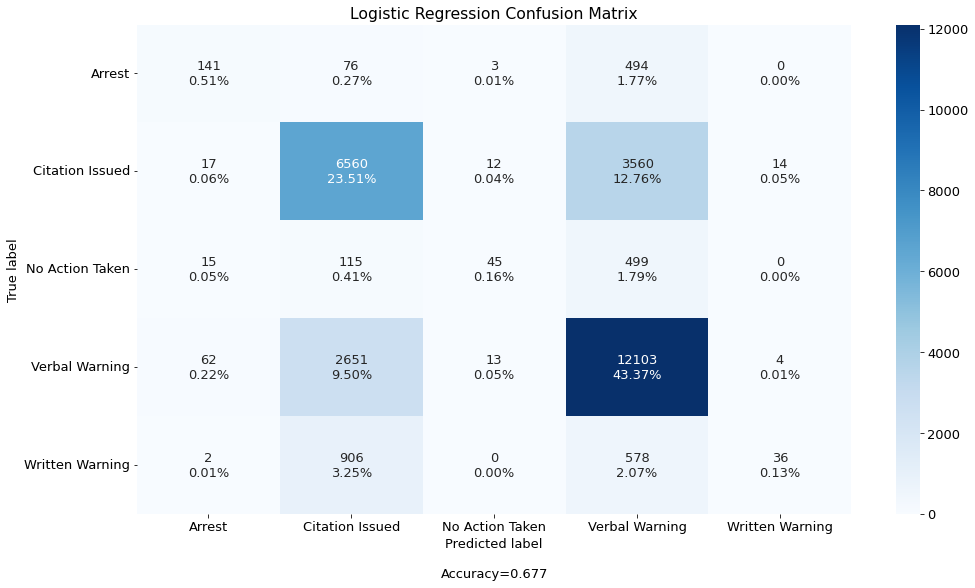

In [25]:
from sklearn.linear_model import LogisticRegression
evaluateModel(LogisticRegression(multi_class='ovr'),title="Logistic Regression Confusion Matrix",
             save='LogisticRegression.png')

Logistic Regression should be considered our baseline as it is both explainable and accurate. We should expect logistic regression to be favorable as we expect the features to be linearly related. We'll consider using any model that has a baseline above our logistic regression.

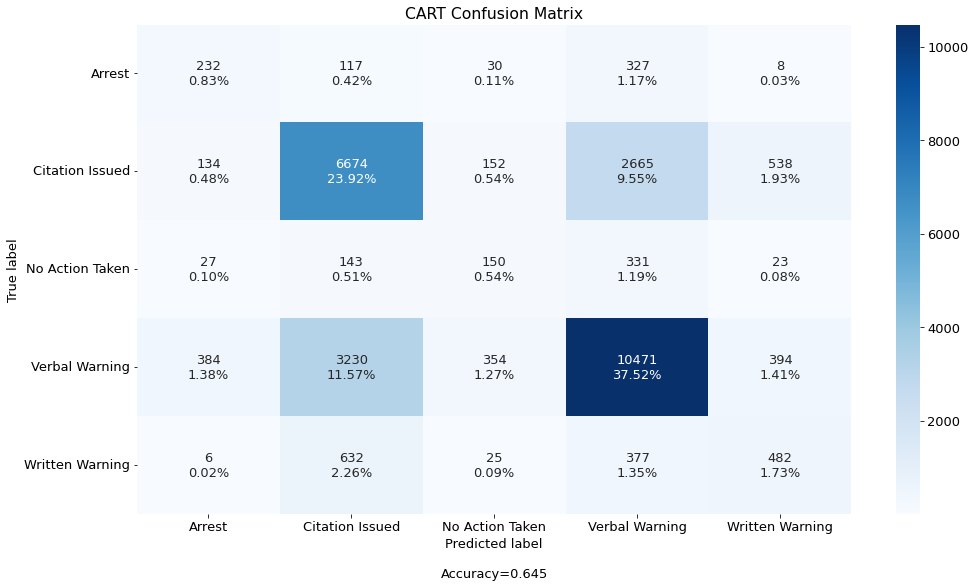

In [26]:
from sklearn.tree import DecisionTreeClassifier
evaluateModel(DecisionTreeClassifier(),title="CART Confusion Matrix")

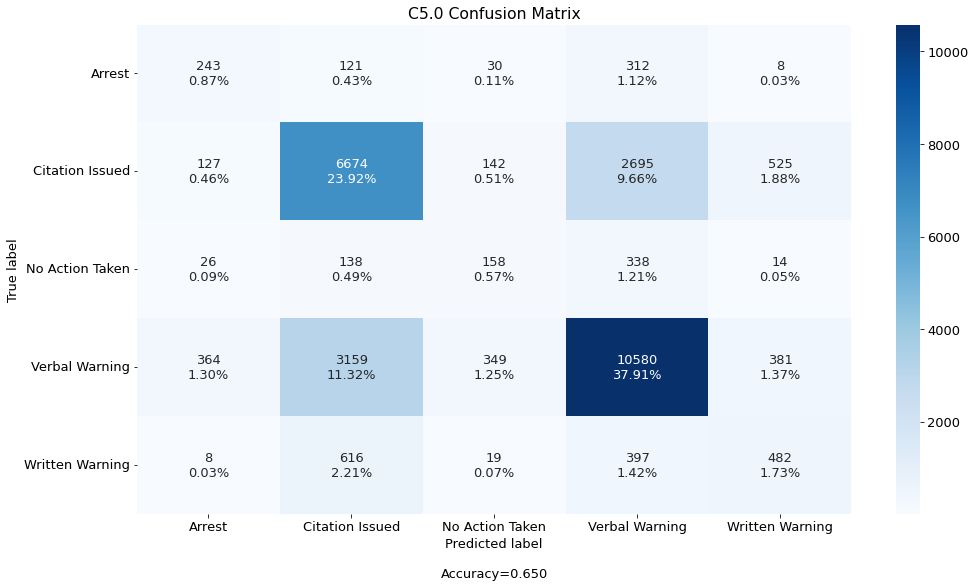

In [27]:
evaluateModel(DecisionTreeClassifier(criterion='entropy'),title='C5.0 Confusion Matrix')

Both Decision Tree models perform worse than our one-vs-rest logistic regression. We won't use either model in the future as they are both less accurate and less explainable than our logistic regression.

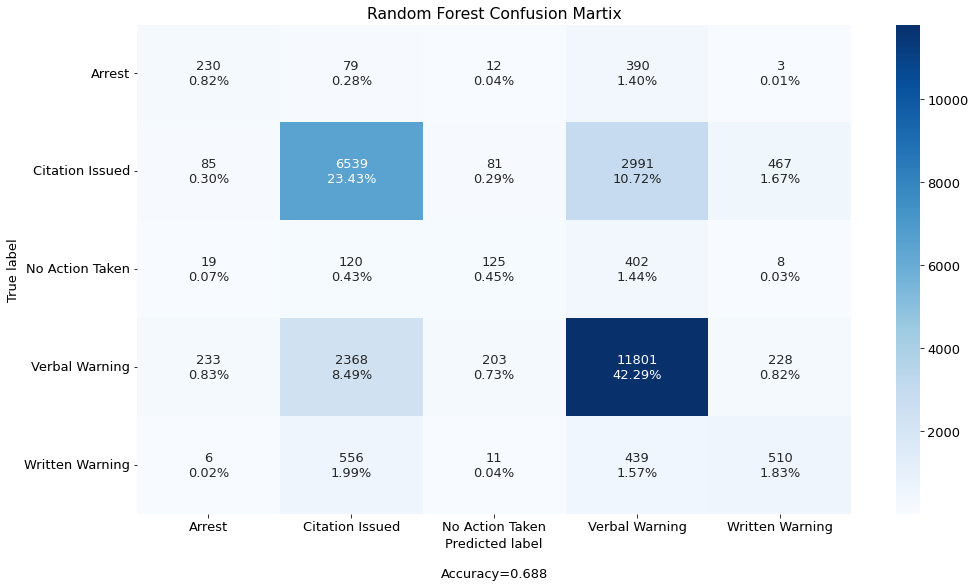

In [28]:
from sklearn.ensemble import RandomForestClassifier
evaluateModel(RandomForestClassifier(),title='Random Forest Confusion Martix')

Our out of the box Random Forest model performed higher than our out of the box logistic regression model. We do lose some interpretability by using a Random Forest, but gain some accuracy.

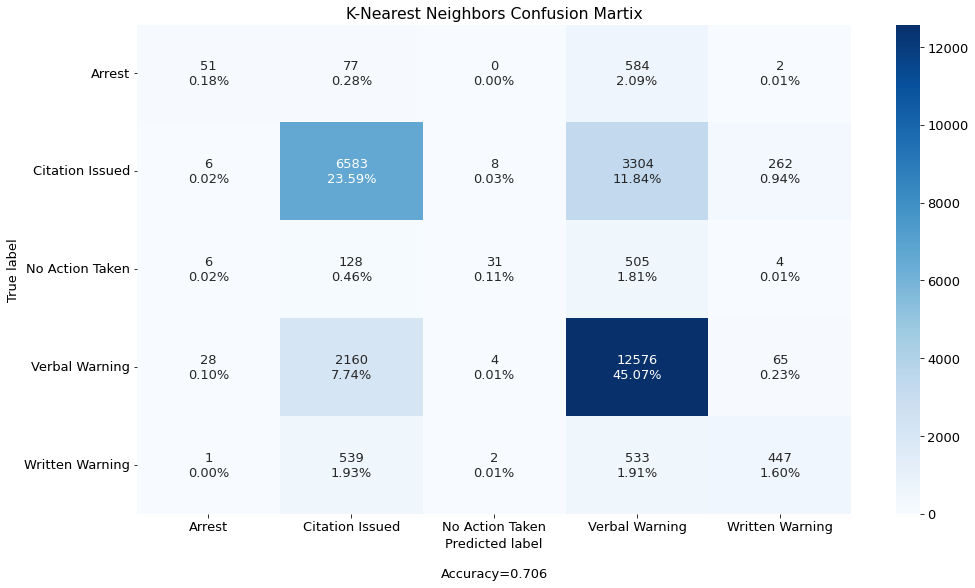

In [29]:
from sklearn.neighbors import KNeighborsClassifier
evaluateModel(KNeighborsClassifier(50),title='K-Nearest Neighbors Confusion Martix')

Our out of the box K-Nearest Neighbors performs the best of any model that we have tested. This model is increadibly interpretable and accurate. The problem with this model is that we likely won't be able to parameter tune this model to be significantly better than it is now unlike Random Forest.

Since we have a decently large dataset that is working to predict multiple classes, we might not want to utilize a support vector machine as support vector classifiers are better when working with 2 classes. Support vector machine classifiers typically only work with binaries and including multiple classes forces the algorithm to do one-vs-many or one-vs-one evaluations. This further becomes a problem as SVMs don't natively support probabilities. Support vector machines can take a long time to run and the time to train increases not only with the number of records, but the number of features. This means when we have a large amount of records and multi-class targets, we might be better off using other choices.

## Feature Engineering and Parameter Tuning
Let's go through and tune our models. For out logistic regression, we'll need to go through and creatively feature engineer. For our other models we'll utilize a grid search to find the optimal parameters. We'll evaluating our performance by using cross validation on our training set. We'll go through parameter tune Random Forest and KNN first.

In [30]:
from sklearn.model_selection import GridSearchCV
'''RF_params = {'n_estimators':[2,4,8,16,32,64,100,200],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[2,4,8,16,32,64,100,200],
             'min_samples_split':[2,4,8,16,32,64,100,200],
             'random_state':[183]}
RF_grid_search = GridSearchCV(RandomForestClassifier(random_state=1),param_grid=RF_params,
                              n_jobs=-1,cv=10,verbose=5)
RF_grid_search.fit(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop'])
print('Train Accuracy : %.3f'%RF_grid_search.best_estimator_.score(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop']))
print('Test Accuracy : %.3f'%RF_grid_search.best_estimator_.score(test_set.drop(columns =['Result_of_Stop']),
                   test_set['Result_of_Stop']))
print('Best Accuracy Through Grid Search : %.3f'%RF_grid_search.best_score_)
print('Best Parameters : ',RF_grid_search.best_params_)'''

"RF_params = {'n_estimators':[2,4,8,16,32,64,100,200],\n             'criterion':['gini','entropy','log_loss'],\n             'max_depth':[2,4,8,16,32,64,100,200],\n             'min_samples_split':[2,4,8,16,32,64,100,200],\n             'random_state':[183]}\nRF_grid_search = GridSearchCV(RandomForestClassifier(random_state=1),param_grid=RF_params,\n                              n_jobs=-1,cv=10,verbose=5)\nRF_grid_search.fit(train_set.drop(columns =['Result_of_Stop']),\n                   train_set['Result_of_Stop'])\nprint('Train Accuracy : %.3f'%RF_grid_search.best_estimator_.score(train_set.drop(columns =['Result_of_Stop']),\n                   train_set['Result_of_Stop']))\nprint('Test Accuracy : %.3f'%RF_grid_search.best_estimator_.score(test_set.drop(columns =['Result_of_Stop']),\n                   test_set['Result_of_Stop']))\nprint('Best Accuracy Through Grid Search : %.3f'%RF_grid_search.best_score_)\nprint('Best Parameters : ',RF_grid_search.best_params_)"

Note the previous code was commented out as the block takes a significant amount of time (5 hours) to run as it needs to train roughly 15000 models. The best parameters found are shown in the screen shot below. We'll keep use these parameters for our random forest model.

Now we'll run a grid search for KNN. This should take far less time as there are less parameters for us to tune. We'll only tune for the weights and the number of neighbors.

In [31]:
'''KNN_params = {'n_neighbors':[5,10,25,50,100,200],
             'weights':['uniform','distance']}
KNN_grid_search = GridSearchCV(KNeighborsClassifier(),param_grid=KNN_params,
                              n_jobs=-1,cv=10,verbose=5)
KNN_grid_search.fit(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop'])
print('Train Accuracy : %.3f'%KNN_grid_search.best_estimator_.score(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop']))
print('Test Accuracy : %.3f'%KNN_grid_search.best_estimator_.score(test_set.drop(columns =['Result_of_Stop']),
                   test_set['Result_of_Stop']))
print('Best Accuracy Through Grid Search : %.3f'%KNN_grid_search.best_score_)
print('Best Parameters : ',KNN_grid_search.best_params_)'''

"KNN_params = {'n_neighbors':[5,10,25,50,100,200],\n             'weights':['uniform','distance']}\nKNN_grid_search = GridSearchCV(KNeighborsClassifier(),param_grid=KNN_params,\n                              n_jobs=-1,cv=10,verbose=5)\nKNN_grid_search.fit(train_set.drop(columns =['Result_of_Stop']),\n                   train_set['Result_of_Stop'])\nprint('Train Accuracy : %.3f'%KNN_grid_search.best_estimator_.score(train_set.drop(columns =['Result_of_Stop']),\n                   train_set['Result_of_Stop']))\nprint('Test Accuracy : %.3f'%KNN_grid_search.best_estimator_.score(test_set.drop(columns =['Result_of_Stop']),\n                   test_set['Result_of_Stop']))\nprint('Best Accuracy Through Grid Search : %.3f'%KNN_grid_search.best_score_)\nprint('Best Parameters : ',KNN_grid_search.best_params_)"

While this code block takes far less time, we still commented it out as it can still take a decent amount of time. As before the screen shot of the best params is attached below.
Now we can finally move onto feature engineering our logistic regression parts.

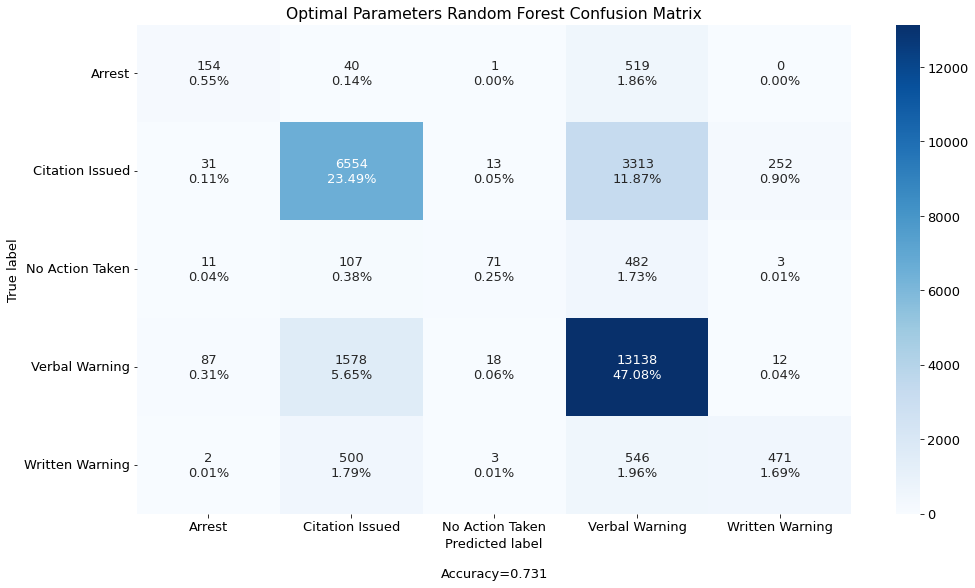

In [32]:
evaluateModel(RandomForestClassifier(criterion='gini',
                                    max_depth=200,
                                    min_samples_split=32,
                                    n_estimators=64),
             title='Optimal Parameters Random Forest Confusion Matrix',
             save='RandomForest.png')

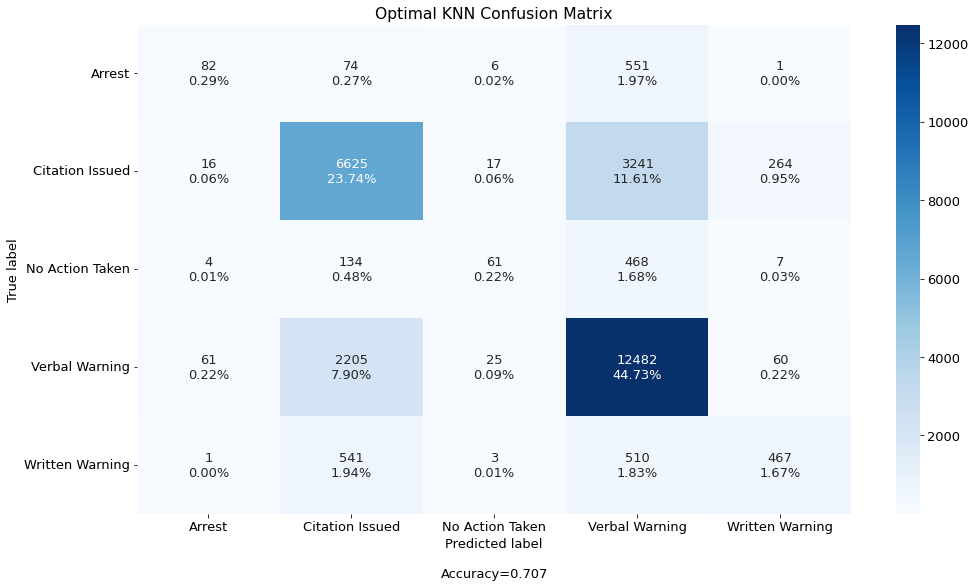

In [33]:
evaluateModel(KNeighborsClassifier(25,weights='uniform'),
             title='Optimal KNN Confusion Matrix')

Now we'll go through and feature engineer our logistic regression model. This is because unlike tree-based models like Random Forest, Logistic Regression cannot encapsulate the interaction between features by itself. Because of this we need to add interaction terms between variables in order to capture these feature interactions. Let's double check what our features are for our original dataset.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139528 entries, 0 to 139527
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Officer_Years_of_Service                    139528 non-null  float64
 1   Driver_Age                                  139528 non-null  float64
 2   Was_a_Search_Conducted                      139528 non-null  object 
 3   Result_of_Stop                              139528 non-null  int32  
 4   Reason_for_Stop_CheckPoint                  139528 non-null  uint8  
 5   Reason_for_Stop_Driving While Impaired      139528 non-null  uint8  
 6   Reason_for_Stop_Investigation               139528 non-null  uint8  
 7   Reason_for_Stop_Other                       139528 non-null  uint8  
 8   Reason_for_Stop_Safe Movement               139528 non-null  uint8  
 9   Reason_for_Stop_SeatBelt                    139528 non-null  uint8  
 

The first thing we should do is consider reducing the amount of features we have. We'll utilize the graphs from the first part to make our decision. We'll drop the races other than white and black as these don't have enough data/information to be utilized properly. We'll also drop all officer races except for white, black and Asian for the same reason. Finally we'll drop the checkpoint and other reason for stop because they also don't have enough data in them. Since gender is binary, we can also drop one of the genders. In this case we'll drop the female gender category.

In [35]:
engineered_df = df.drop(columns=['Driver_Race_Asian','Driver_Race_Other/Unknown',
                                 'Driver_Race_Native American','Officer_Race_2 or More',
                                 'Officer_Race_American Indian/Alaska Native','Officer_Race_Not Specified',
                                 'Officer_Race_Hispanic/Latino','Reason_for_Stop_Other                    ',
                                 'Reason_for_Stop_CheckPoint               ',
                                'Driver_Gender_Female'])

Now let's create some interaction variables. First we'll create an interaction between age and driver race. We'll also add an interaction between driver race and gender.

In [36]:
for race in ['Driver_Race_Black','Driver_Race_White']:
    engineered_df['Agex'+race] = engineered_df[race] * engineered_df['Driver_Age']
    engineered_df['Genderx'+race] = engineered_df[race] * engineered_df['Driver_Gender_Male']
    for column in cmpd_divisions:
        engineered_df[f'{column}x{race}'] = engineered_df[race] * engineered_df[f'CMPD_Division_{column}']

Our interaction variables are now in our dataframe and we can proceed to modeling our logistic regression. Let's remake our train test split with our new dataset.

In [37]:
train_set, test_set = train_test_split(engineered_df,test_size=.2,random_state=1994)
getBaseline(test_set['Result_of_Stop'],label_encoder=le)

Baseline accuracy is 0.5315344370386297% by predicting all Verbal Warning



Now let's re-run our models.

C:\Users\sulli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


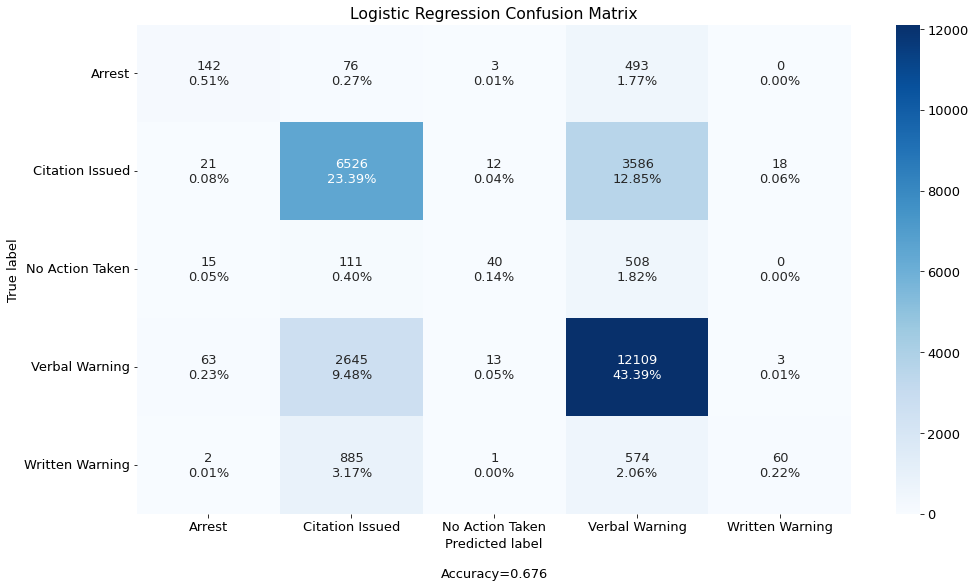

In [38]:
evaluateModel(LogisticRegression(multi_class='ovr'),train_set=train_set,
              test_set=test_set,title="Logistic Regression Confusion Matrix")

We actually lost some performance while doing this. One last thing we can try to improve model performance is to **rebalance** our training set. Let's look at our value counts for our target variable. We'll use the percentage for our count.

In [39]:
engineered_df['Result_of_Stop'].value_counts(normalize=True)

3    0.531435
1    0.364034
4    0.055236
0    0.024827
2    0.024468
Name: Result_of_Stop, dtype: float64

In [40]:
keys

array(['Arrest', 'Citation Issued', 'No Action Taken', 'Verbal Warning',
       'Written Warning'], dtype=object)

Looking at this, we should consider rebalancing the classes so that at minimum they make up 10% of the original data's legth. Lukcily we have already written a function for rebalancing implemented logic for it in our evaluate model function. All we need to do is pass in a dictionary to the rebalance argument. 

C:\Users\sulli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


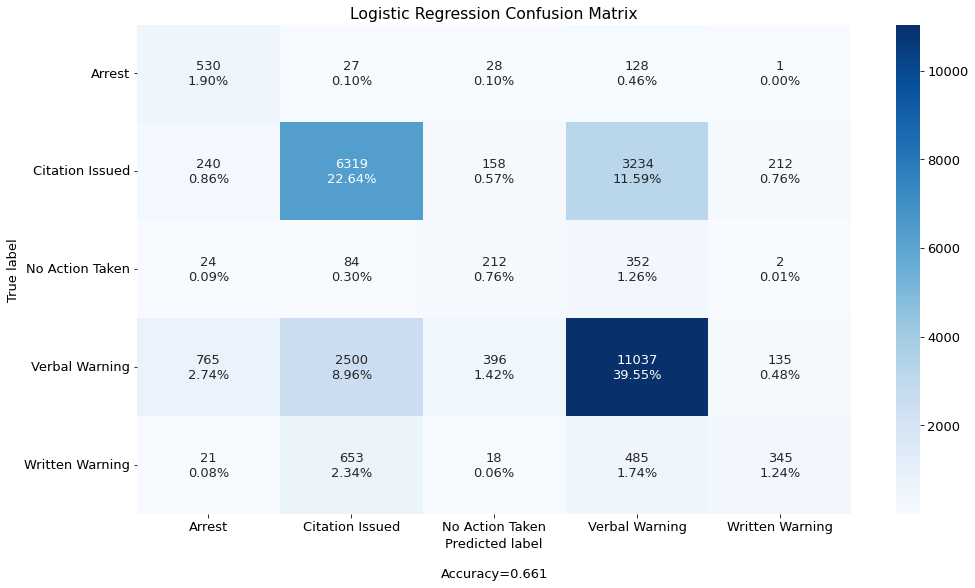

In [41]:
rebalance_dict = {4:.1,0:.1,2:.1}
evaluateModel(LogisticRegression(multi_class='ovr'),train_set=train_set,
              test_set=test_set,title="Logistic Regression Confusion Matrix",
             rebalance=rebalance_dict)

We can see that rebalancing our classes changed our accuracy. Written warning was predicted more often and was able to be classified correctly more often. Let's **loop** through a couple of diffent rebalancing parameters to find the optimal balancing. Unfortunately we cannot use K-fold cross validation to optimize for this as rebalancing the training set would also affect what is being evaluated. Instead we will go back through and resplit our data into 3 partitions this time: train, validation, and test. We will rebalance the train data and compare it to the validation data. Once we find the best parameters according to the validation data, we will test the data against the test set. Doing this is the best way to reduce bias in our tuning. We'll accomplish this by splitting our original train set using train test split.

In [42]:
val_train, val_test = train_test_split(train_set,test_size=.25,random_state = 224)

Now we can finally loop through this to find the best rebalancing values.

In [43]:
from IPython.display import clear_output
"""rebalance_values = [0,.05,.1,.15,.2]
current_max = 0
current_params =[0,0,0]
for first in rebalance_values:
    for second in rebalance_values:
        for third in rebalance_values:
            resize_dict = {4:first,0:second,2:third}
            train_set_copy = resampleTrainingSet(val_train,resize_dict)
            clf = LogisticRegression(multi_class='ovr').fit(train_set_copy.drop(columns=['Result_of_Stop']),
                                                            train_set_copy['Result_of_Stop'])
            val_pred = clf.predict(val_test.drop(columns=['Result_of_Stop']))
            current_score = accuracy_score(val_pred,val_test['Result_of_Stop'])
            clear_output()
            if current_score > current_max:
                current_max = current_score
                current_params = [first,second,third]
print(f'Best rebalance score: {current_max}')
print(f'Best rebalance params: {current_params}')"""

"rebalance_values = [0,.05,.1,.15,.2]\ncurrent_max = 0\ncurrent_params =[0,0,0]\nfor first in rebalance_values:\n    for second in rebalance_values:\n        for third in rebalance_values:\n            resize_dict = {4:first,0:second,2:third}\n            train_set_copy = resampleTrainingSet(val_train,resize_dict)\n            clf = LogisticRegression(multi_class='ovr').fit(train_set_copy.drop(columns=['Result_of_Stop']),\n                                                            train_set_copy['Result_of_Stop'])\n            val_pred = clf.predict(val_test.drop(columns=['Result_of_Stop']))\n            current_score = accuracy_score(val_pred,val_test['Result_of_Stop'])\n            clear_output()\n            if current_score > current_max:\n                current_max = current_score\n                current_params = [first,second,third]\nprint(f'Best rebalance score: {current_max}')\nprint(f'Best rebalance params: {current_params}')"

It appears that our best rebalance parameters for accuracy are for us to rebalance the written warning target to be 10% of the origninal data. Let's see how this model performs during logistic regression. Note that the 0s in our best params rebalance don't affect the rebalance as the logic of the function we used prevents down sampling.

C:\Users\sulli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


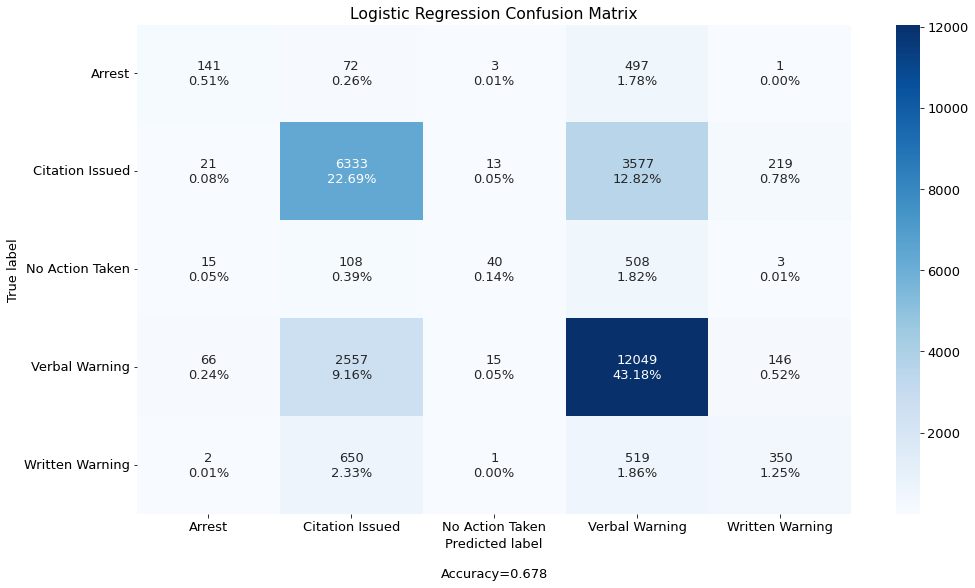

In [44]:
rebalance_dict = {4:.1,0:0,2:0}
evaluateModel(LogisticRegression(multi_class='ovr'),train_set=train_set,
              test_set=test_set,title="Logistic Regression Confusion Matrix",
             rebalance=rebalance_dict)

Let's now rebalance our training data set.

In [45]:
train_set = resampleTrainingSet(train_set,{4:.1})

As we can see this is better than our previous model. The last thing we will try is to model and parameter tune our Random Forest model under these new conditions. We need to do this as we drop some features and also rebalanced the dataset.  Let's re-run our parameter tuning again using grid search. Note that this time we'll be using gini as our criterion so that we can reduce the time  to compute by a factor of 3.

In [46]:
"""RF_params = {'n_estimators':[2,4,8,16,32,64,100,200],
             'max_depth':[2,4,8,16,32,64,100,200],
             'min_samples_split':[2,4,8,16,32,64,100,200],
             'random_state':[183]}
RF_grid_search = GridSearchCV(RandomForestClassifier(criterion='gini'),param_grid=RF_params,
                              n_jobs=-1,cv=10,verbose=5)
RF_grid_search.fit(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop'])
print('Train Accuracy : %.3f'%RF_grid_search.best_estimator_.score(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop']))
print('Test Accuracy : %.3f'%RF_grid_search.best_estimator_.score(test_set.drop(columns =['Result_of_Stop']),
                   test_set['Result_of_Stop']))
print('Best Accuracy Through Grid Search : %.3f'%RF_grid_search.best_score_)
print('Best Parameters : ',RF_grid_search.best_params_)"""

"RF_params = {'n_estimators':[2,4,8,16,32,64,100,200],\n             'max_depth':[2,4,8,16,32,64,100,200],\n             'min_samples_split':[2,4,8,16,32,64,100,200],\n             'random_state':[183]}\nRF_grid_search = GridSearchCV(RandomForestClassifier(criterion='gini'),param_grid=RF_params,\n                              n_jobs=-1,cv=10,verbose=5)\nRF_grid_search.fit(train_set.drop(columns =['Result_of_Stop']),\n                   train_set['Result_of_Stop'])\nprint('Train Accuracy : %.3f'%RF_grid_search.best_estimator_.score(train_set.drop(columns =['Result_of_Stop']),\n                   train_set['Result_of_Stop']))\nprint('Test Accuracy : %.3f'%RF_grid_search.best_estimator_.score(test_set.drop(columns =['Result_of_Stop']),\n                   test_set['Result_of_Stop']))\nprint('Best Accuracy Through Grid Search : %.3f'%RF_grid_search.best_score_)\nprint('Best Parameters : ',RF_grid_search.best_params_)"

Just like before, this code block took some time to run so it was commeneted out. This screenshot shows the optimal parameters found.

In [ ]:
evaluateModel(RandomForestClassifier(max_depth=32,min_samples_split=8,
                           n_estimators=200),title='Random Forest Confusion Matrix')

Our final model accuracy for this feature engineered dataset was 72% accurate. This performed worse than our other Random Forest model so we will use the other model instead. 


## Model Decision
If our goal is accurate predictions, then we will utilize the Random Forest model with all of the dummy variables and no interaction variables. If our goal is explainability, then we will utilize the one-vs-rest logistic regression model as it can very easily explain the importance and direction of features.

In [ ]:
train_set, test_set = train_test_split(df,test_size=.2,random_state=1994)
RF = RandomForestClassifier(criterion='gini',
                                    max_depth=200,
                                    min_samples_split=32,
                                    n_estimators=64).fit(train_set.drop(columns =['Result_of_Stop']),
                   train_set['Result_of_Stop'])

## Feature Importances
Now that we have an accurate model, we need to evaluate what features it utilizes the most. This will hopefully tell us how weighted the driver demographics are in the result of a stop. Let's create a dataframe that represents the features and their importance in our model. Note that we want to ignore any feature that doesn't contain any importance. 

In [ ]:
importance_df = pd.DataFrame(list(zip(df.drop(columns=['Result_of_Stop']).columns,
                                     RF.feature_importances_)),
                            columns=['Feature','Importance'])
importance_df = importance_df[importance_df['Importance'] != 0]
importance_df = importance_df.sort_values("Importance",ascending=False)

Now let's create a bar plot that shows the feature importance for every feature.

In [ ]:
plt.figure(figsize=(12,20))
sns.barplot(x=importance_df['Importance'],y=importance_df['Feature'],
           palette = sns.color_palette("ch:start=.2,rot=-.3_r",n_colors=len(importance_df)))
plt.title('Feature Importance Plot')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig("Feature_Importance.png",bbox_inches='tight')
plt.show()

While this plot is good for showcasing how the model makes it's decisions, it would likely be better to aggregate it into our original features. We'll lose some information when doing this, but gain some interpretability.

In [ ]:
reason_for_stop = importance_df[importance_df['Feature'].str.contains('Reason_for_Stop')]['Importance'].sum()
driver_race = importance_df[importance_df['Feature'].str.contains('Driver_Race')]['Importance'].sum()
division = importance_df[importance_df['Feature'].str.contains('CMPD_Division')]['Importance'].sum()
Years_of_Service = importance_df[importance_df['Feature']=='Officer_Years_of_Service']['Importance'].sum()
Driver_Age = importance_df[importance_df['Feature']=='Driver_Age']['Importance'].sum()
Officer_Race = importance_df[importance_df['Feature'].str.contains('Officer_Race')]['Importance'].sum()
Driver_Ethnicity = importance_df[importance_df['Feature'].str.contains('Driver_Ethnicity')]['Importance'].sum()
Driver_Gender = importance_df[importance_df['Feature'].str.contains('Driver_Gender')]['Importance'].sum()
Search_Conducted = importance_df[importance_df['Feature'].str.contains('Was_a_Search_Conducted')]['Importance'].sum()

We need to make sure that we aren't missing any features, so we'll add up all of the aggregated features and ensure they add up to 1.

In [ ]:
reason_for_stop + driver_race + division + Years_of_Service + Driver_Age + Officer_Race + Driver_Ethnicity + Driver_Gender+Search_Conducted

It looks like we have our feature weights correct. Let's now go through and create one more dataframe with the adjusted feature importances.

In [ ]:
variable_names = ['Reason for Stop','Driver Race','CMPD Division','Years of Service','Driver Age','Officer Race',
                 'Driver Ethnicity','Driver Gender',"Search Conducted"]
variable_weights = [reason_for_stop*100,driver_race*100, division*100, Years_of_Service*100,
                    Driver_Age*100, Officer_Race*100, Driver_Ethnicity*100,Driver_Gender*100,Search_Conducted*100]
importance_df2 = pd.DataFrame(list(zip(variable_names,variable_weights)),
                             columns=['Feature','Importance']).sort_values('Importance',
                                                                          ascending=False)

Finally we'll include a new feature importance graph that is more interpretable.

In [ ]:
matplotlib.rcParams.update({'font.size':22})

In [ ]:
plt.figure(figsize=(16,9))
sns.barplot(x=importance_df2['Importance'],y=importance_df2['Feature'],
           palette = sns.color_palette("ch:start=.2,rot=-.3_r",n_colors=len(importance_df)))
plt.title('Variable Importance')
plt.xlabel('Percent of Decision')
plt.ylabel('Variable')
plt.savefig("Feature_Importance2.png",bbox_inches='tight')
plt.show()

## Statisical model approach
Let's analyze our results from a more statistical trend approach. We'll creat a logit model for each class of result of stop and analyze what this means.

In [ ]:
import statsmodels.api as sma

In [ ]:
index = 0
for result in df['Result_of_Stop'].unique():
    df['Target'] = [0] * len(df)
    df.loc[df['Result_of_Stop'] == result,'Target'] = 1
    clf = sma.Logit(df['Target'],df.drop(columns=['Result_of_Stop','Target'])).fit()
    print(f'{keys[index]} Logit Model:')
    print(clf.summary())
    print('------------------------------------\n')
    index+=1

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7087fd09-16b2-4a81-aa46-3d25b55b1033' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>